# README.

This notebook shows how to do some very basic analysis of the measurements.

In [ ]:
!echo '{"dbname": "...", "user": "...@...", "host": "...", "password": "...", "port": ..., "sslmode": "require"}' > dbconnection.json
!cat dbconnection.json

In [3]:
%matplotlib inline
import dbutils
import pandas as pd
import matplotlib.pyplot as plt
import os

# Where to store outputs.
output_path = "."

# Connect to database.
main_connector = dbutils.connect_to_main_database()

# Getting the columns of the tables.

In [4]:
for table in ["artifact", "measure", "person"]:
    print(table, "\n\t", "\n\t".join(main_connector.get_columns(table)))

artifact 
	 id
	type
	path
	hash_value
	filesize
	upload_date
	deleted
	qr_code
	create_date
	created_by
	status
measure 
	 id
	person_id
	date
	type
	age
	height
	weight
	muac
	head_circumference
	artifact
	visible
	oedema
	timestamp
	created_by
	deleted
	deleted_by
person 
	 id
	name
	surname
	birthday
	sex
	guardian
	is_age_estimated
	qr_code
	created
	timestamp
	created_by
	deleted
	deleted_by


# Getting statistical values of measurements.

In [5]:
columns = [
 'age',
 'height',
 'weight',
 'muac',
 'head_circumference',
]

headers = []
rows = []
for column in columns:
    sql_statement = "SELECT MIN({0}), AVG({0}), MAX({0}) FROM measure;".format(column)
    minimum, average, maximum = main_connector.execute(sql_statement, fetch_one=True)
    
    rows.append([column, minimum, average, maximum])
    
headers = ("key", "minimum", "average", "maximum")
df = pd.DataFrame(rows, columns=headers)
df

,key,minimum,average,maximum
0,age,32523.0,32523.000000000000,32523.0
1,height,23.0,23,23.0
2,weight,24.0,24,24.0
3,muac,235.0,235,235.0
4,head_circumference,345.0,345,345.0


In [6]:
max_age_days = 6 * 30
sql_statement = ""
sql_statement += "SELECT COUNT(*) FROM measure"
sql_statement += " WHERE age < {}".format(max_age_days)
sql_statement += " AND type=\'manual\'"
main_connector.execute(sql_statement, fetch_one=True)

(0,)

# Creating pie charts for some columns.

('anubhav',) 1
(True,) 1


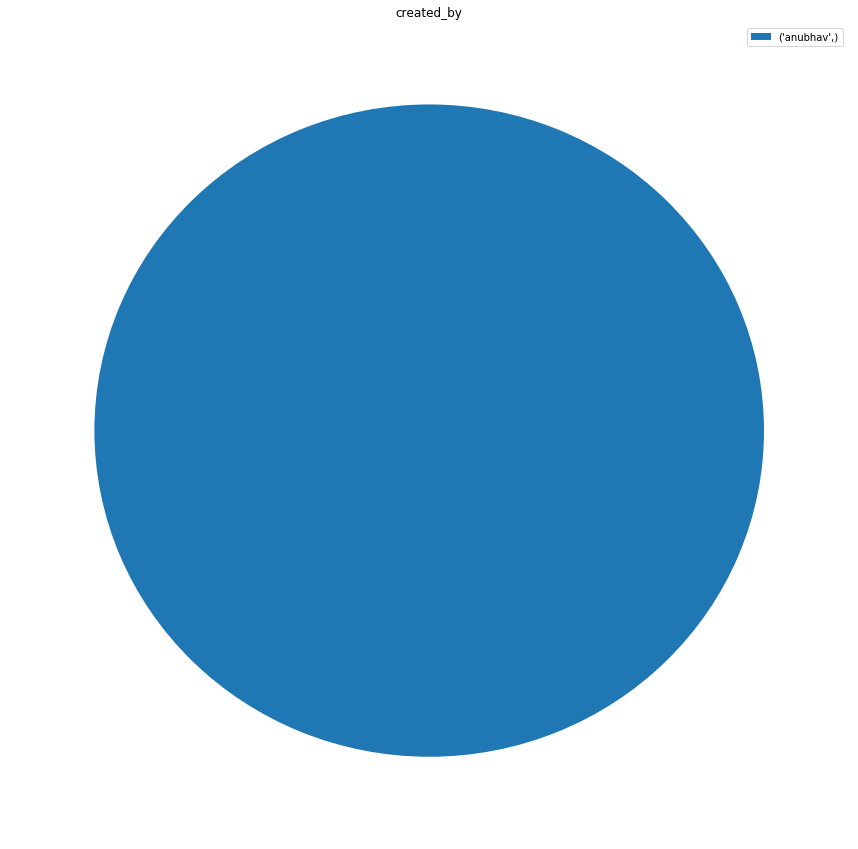

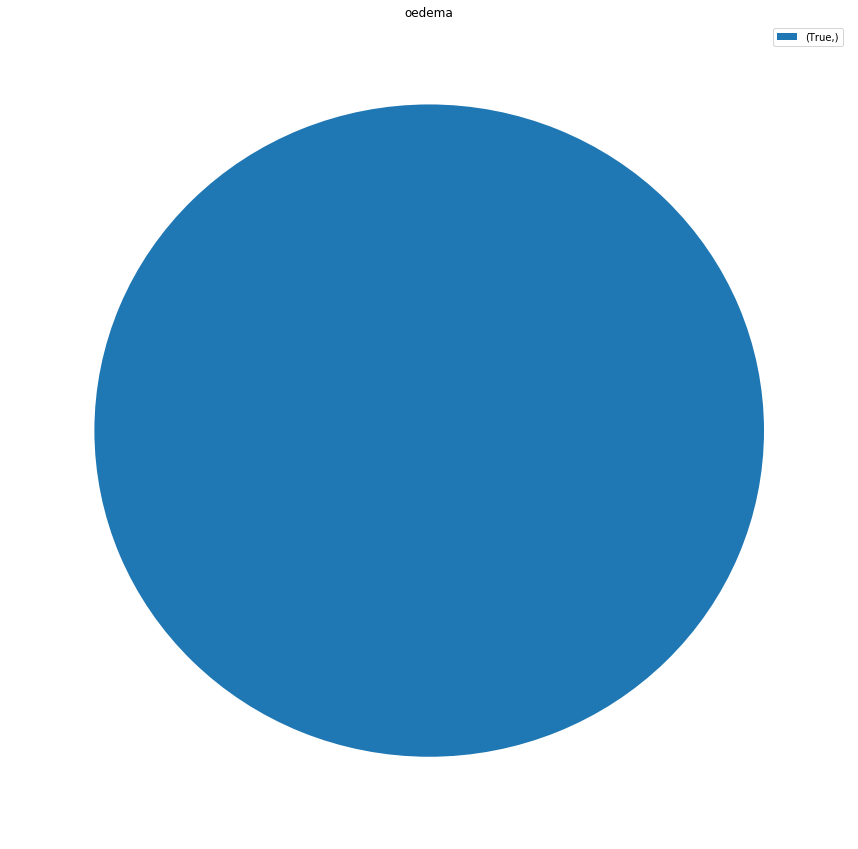

In [7]:
from collections import Counter

def make_pie(key):
    sql_statement = "SELECT {} FROM measure;".format(key)
    values_list = main_connector.execute(sql_statement, fetch_all=True)

    most_common = Counter(values_list).most_common(10000)

    # TODO percent
    values = []
    keys = []
    for key, value in most_common:
        print(key, value)
        keys.append(str(key))
        values.append(value)
        
    plt.figure(figsize=(15, 15))
    patches, texts = plt.pie(values)
    plt.legend(patches, keys)
    plt.title(df_key)
    plt.savefig(os.path.join(output_path, "pie-{}.png".format(df_key)))

    
df_keys = ["created_by", "oedema"]
for df_key in df_keys:
    make_pie(df_key)

# Render histograms.

[]


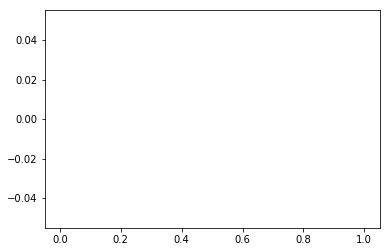

[]


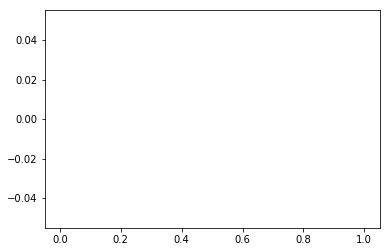

[]


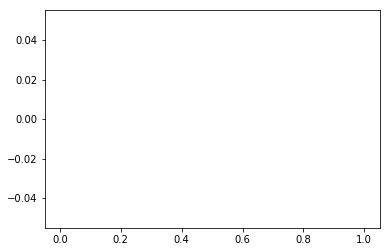

[]


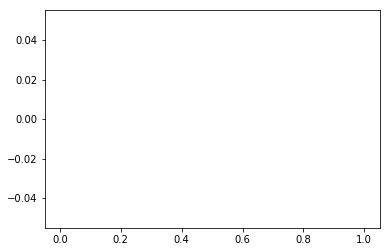

In [8]:
def render_histogram(key, values, bins):
    hist = plt.hist(values, bins=bins)
    plt.savefig("histogram-{}.png".format(key))
    plt.show()
    
render_parameters = []
render_parameters.append(("age", 100))
render_parameters.append(("height", 100))
render_parameters.append(("weight", 100))
render_parameters.append(("muac", 100))
for key, bins in render_parameters:
    sql_statement = "SELECT {} FROM measure WHERE type='manual'".format(key)
    results = main_connector.execute(sql_statement, fetch_all=True)
    values = [result[0] for result in results]
    print(values[0:10])
    render_histogram(key, values, bins)

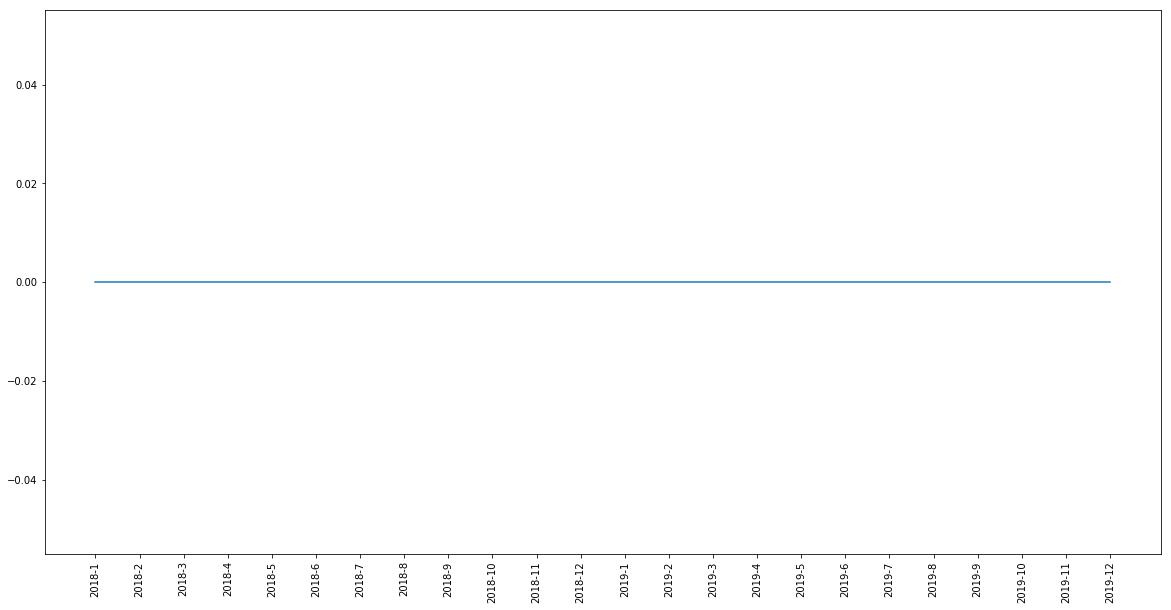

In [9]:
from datetime import date
from time import mktime
import calendar

plot_values = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the number of entries from the database.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM measure"
        sql_statement += " WHERE type='manual'"
        sql_statement += " AND timestamp >= {}".format(start_timestamp)
        sql_statement += " AND timestamp <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        
        # Prepare the plot.
        plot_values.append(number_of_entries)
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20,10))
plt.plot(plot_values)
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.show()
plt.close()